# Perform logreg on acoustic measures

Input large df with acoustic measures for each vowel in each word and output feature importance.

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold as kfold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.cbook as cbook

In [17]:
df = pd.read_csv("data/data_bigPCA.csv")
df['syllable'] = np.where((df['Label']=="i") | (df['Label']=="pen"), 'pen', 'ult')
df.sample(20, random_state = 10)

,dur_creak,f0_spec,vowel_periph,Filename,Label,partID,Language,t1_wd,t2_wd,word,stress,syllable
5845,-2.164290,1.767214,1.556790,als086_english_exp2_g.mat,ult,als086,eng,56.478319,56.979500,import,0,ult
14780,0.855463,0.570224,-0.775789,lnd078_english_exp2_b.mat,pen,lnd078,eng,18.993300,19.366341,record,0,pen
27505,-0.522600,-2.100273,-0.412922,rrl106_english_exp2_f.mat,ult,rrl106,eng,25.469200,26.029200,project,0,ult
24379,0.013192,-1.632876,-1.571611,irm109_catalan_exp2_c.mat,a,irm109,cat,62.762200,63.284829,determina,0,ult
25043,1.634092,-3.805998,-0.494500,lic063_english_exp2_f.mat,ult,lic063,eng,46.427726,46.907801,combine,1,ult
27287,-2.454391,-0.686511,-0.776888,osl017_english_exp2_d.mat,ult,osl017,eng,82.053361,82.414100,impress,0,ult
7392,-2.227305,4.152288,1.282938,aps124_english_exp2_d.mat,pen,aps124,eng,8.366000,8.756000,incite,0,pen
8302,-2.206763,3.845567,1.232736,arl041_catala_exp2_c.mat,i,arl041,cat,101.741700,102.141700,il·luminar,0,pen
8602,-2.261606,2.535089,1.529227,arl041_spanish_exp2_c.mat,i,arl041,spa,50.461500,51.034589,denominó,0,pen
6675,-2.571841,-1.792520,-1.416365,anf025_english_exp2_c.mat,ult,anf025,eng,72.840600,73.120600,desert,0,ult


In [18]:
df['word'].mask(df['word'] == 'billow', 'below', inplace=True)
df['word'].mask(df['word'] == 'forebear', 'forbear', inplace=True)
df['word'].mask(df['word'] == 'insight', 'incite', inplace=True)
df['word'].mask(df['word'] == 'trustee', 'trusty', inplace=True)
df.sample(20, random_state = 10)

,dur_creak,f0_spec,vowel_periph,Filename,Label,partID,Language,t1_wd,t2_wd,word,stress,syllable
5845,-2.164290,1.767214,1.556790,als086_english_exp2_g.mat,ult,als086,eng,56.478319,56.979500,import,0,ult
14780,0.855463,0.570224,-0.775789,lnd078_english_exp2_b.mat,pen,lnd078,eng,18.993300,19.366341,record,0,pen
27505,-0.522600,-2.100273,-0.412922,rrl106_english_exp2_f.mat,ult,rrl106,eng,25.469200,26.029200,project,0,ult
24379,0.013192,-1.632876,-1.571611,irm109_catalan_exp2_c.mat,a,irm109,cat,62.762200,63.284829,determina,0,ult
25043,1.634092,-3.805998,-0.494500,lic063_english_exp2_f.mat,ult,lic063,eng,46.427726,46.907801,combine,1,ult
27287,-2.454391,-0.686511,-0.776888,osl017_english_exp2_d.mat,ult,osl017,eng,82.053361,82.414100,impress,0,ult
7392,-2.227305,4.152288,1.282938,aps124_english_exp2_d.mat,pen,aps124,eng,8.366000,8.756000,incite,0,pen
8302,-2.206763,3.845567,1.232736,arl041_catala_exp2_c.mat,i,arl041,cat,101.741700,102.141700,il·luminar,0,pen
8602,-2.261606,2.535089,1.529227,arl041_spanish_exp2_c.mat,i,arl041,spa,50.461500,51.034589,denominó,0,pen
6675,-2.571841,-1.792520,-1.416365,anf025_english_exp2_c.mat,ult,anf025,eng,72.840600,73.120600,desert,0,ult


In [19]:
df['word'].mask((df['Language']!="eng") & (~df['word'].str.endswith("r")), df['word'].str[:-1], inplace = True)
df['word'].mask((df['Language']!="eng") & (df['word'].str.endswith("r")), df['word'].str[:-2], inplace = True)
df.sample(20, random_state = 10)

,dur_creak,f0_spec,vowel_periph,Filename,Label,partID,Language,t1_wd,t2_wd,word,stress,syllable
5845,-2.164290,1.767214,1.556790,als086_english_exp2_g.mat,ult,als086,eng,56.478319,56.979500,import,0,ult
14780,0.855463,0.570224,-0.775789,lnd078_english_exp2_b.mat,pen,lnd078,eng,18.993300,19.366341,record,0,pen
27505,-0.522600,-2.100273,-0.412922,rrl106_english_exp2_f.mat,ult,rrl106,eng,25.469200,26.029200,project,0,ult
24379,0.013192,-1.632876,-1.571611,irm109_catalan_exp2_c.mat,a,irm109,cat,62.762200,63.284829,determin,0,ult
25043,1.634092,-3.805998,-0.494500,lic063_english_exp2_f.mat,ult,lic063,eng,46.427726,46.907801,combine,1,ult
27287,-2.454391,-0.686511,-0.776888,osl017_english_exp2_d.mat,ult,osl017,eng,82.053361,82.414100,impress,0,ult
7392,-2.227305,4.152288,1.282938,aps124_english_exp2_d.mat,pen,aps124,eng,8.366000,8.756000,incite,0,pen
8302,-2.206763,3.845567,1.232736,arl041_catala_exp2_c.mat,i,arl041,cat,101.741700,102.141700,il·lumin,0,pen
8602,-2.261606,2.535089,1.529227,arl041_spanish_exp2_c.mat,i,arl041,spa,50.461500,51.034589,denomin,0,pen
6675,-2.571841,-1.792520,-1.416365,anf025_english_exp2_c.mat,ult,anf025,eng,72.840600,73.120600,desert,0,ult


In [20]:
parts = pd.read_csv("../blp/data/parts.csv")
parts['partID'] = parts['partID'].map(str.lower)

In [21]:
df_lang = pd.merge(df, parts, on = "partID", how = "left")
df_lang.head()

,dur_creak,f0_spec,vowel_periph,Filename,Label,partID,Language,t1_wd,t2_wd,word,stress,syllable,lang_profile
0,-2.082444,1.975650,-0.034865,afs116_catala_exp2_a.mat,i,afs116,cat,5.502012,6.2491,elimin,0,pen,l1_eng
1,4.574170,3.367846,0.112976,afs116_catala_exp2_a.mat,a,afs116,cat,5.502012,6.2491,elimin,1,ult,l1_eng
2,3.266917,2.909849,1.798839,afs116_catala_exp2_a.mat,i,afs116,cat,10.850600,12.0906,discrimin,0,pen,l1_eng
3,5.502514,3.287846,0.004232,afs116_catala_exp2_a.mat,a,afs116,cat,10.850600,12.0906,discrimin,1,ult,l1_eng
4,4.762114,2.906207,1.791159,afs116_catala_exp2_a.mat,i,afs116,cat,40.617489,42.1002,encamin,0,pen,l1_eng


In [22]:
blp_pca = pd.read_csv("../blp/data/pca_blp.csv")
blp_pca.drop(['lang_profile'], axis = 1, inplace = True)
df_blp = pd.merge(df_lang, blp_pca, on="partID", how = "left")

In [23]:
df_blp.drop(['Filename', 't1_wd', 't2_wd'], axis = 1, inplace = True)

In [24]:
df_blp.to_csv("data/big_PCA_forR.csv", index = False)

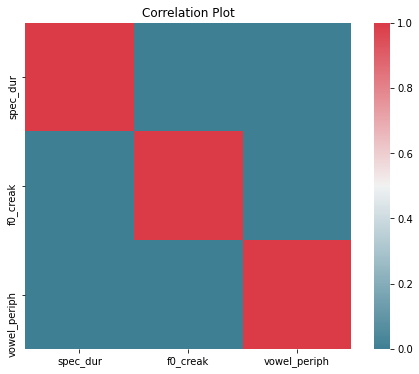

In [10]:
subset = df.drop(['t1_wd', 't2_wd', 'stress'], axis =1)
cor= subset.corr(method='pearson')
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [11]:
df.columns

Index(['spec_dur', 'f0_creak', 'vowel_periph', 'Filename', 'Label', 'partID',
       'Language', 't1_wd', 't2_wd', 'stress', 'syllable'],
      dtype='object')

In [12]:
df.drop(['Filename', 'Label', 't1_wd', 't2_wd'], axis = 1, inplace = True)

Look for empty rows

In [13]:
df.isnull().sum()

spec_dur        0
f0_creak        0
vowel_periph    0
partID          0
Language        0
stress          0
syllable        0
dtype: int64

In [13]:
# y_all = df['stress_wd']
# X_all = df.drop(['stress_wd', 'Language', 'partID'], axis = 1)
    
# rf_classifier = RandomForestClassifier(random_state = 10)
    
# param_grid = { 
#     'n_estimators': [500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : np.arange(4,10,1),
#     'criterion' :['gini', 'entropy']
# }

# CV_rfc = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_all, y_all)
    
# print("Best RF Estimator: ", CV_rfc.best_params_, "\n")
    
# scores = cross_val_score(rf_classifier, X_all, y_all.ravel(), cv=5)
# print("Accuracy over all data: ", scores.mean())
    
# rf_classifier_best = CV_rfc.best_estimator_

# cols = X_all.columns

Best RF Estimator:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500} 

Accuracy over all data:  0.6931242577631553


In [15]:
rf_classifier = RandomForestClassifier(random_state = 10, criterion = "entropy", max_depth = 9,
                                      max_features = 'auto', n_estimators = 500)
init = df[df['syllable']=="pen"].copy()
final = df[df['syllable']=="ult"].copy()
y_init_all = init['stress']
X_init_all = init.drop(['stress', 'Language', 'partID', 'syllable'], axis = 1)

y_final_all = final['stress']
X_final_all = final.drop(['stress', 'Language', 'partID', 'syllable'], axis = 1)

scores_init = cross_val_score(rf_classifier, X_init_all, y_init_all.ravel(), cv=5)
scores_final = cross_val_score(rf_classifier, X_final_all, y_final_all.ravel(), cv=5)
print("Accuracy over all data for penultimate vowels: ", scores_init.mean(),
      "\n Accuracy over all data for ultimate vowels: ", scores_final.mean())

Accuracy over all data for penultimate vowels:  0.6624017155110794 
 Accuracy over all data for ultimate vowels:  0.5872315456952115


In [22]:
df.columns

Index(['spec_dur', 'f0_creak', 'vowel_periph', 'partID', 'Language', 'stress',
       'syllable'],
      dtype='object')

In [17]:
cols = X_init_all.columns

In [25]:
def rf(df, rf_classifier_best, cols):
    lang = []
    partid = []
    dfs = []
    vowel_pos = []
    
    for s in df.syllable.unique():
        data1 = df[df['syllable']==s].copy()
        
        for p in data1.partID.unique():
            data2 = data1[data1['partID']==p].copy()

            for l in data2.Language.unique():
                # isolate language of interest
                data3 = data2[data2['Language']==l].copy()
                data3.drop(['Language', 'partID', 'syllable'], axis = 1, inplace = True)

                # define predictor label
                y = data3['stress']

                # define feature set
                X = data3.drop(['stress'], axis = 1)

                rf_classifier_best.fit(X, y.ravel())
                importances = rf_classifier_best.feature_importances_
                std = np.std([tree.feature_importances_ for tree in rf_classifier_best.estimators_], axis=0)
                q_25 = np.percentile([tree.feature_importances_ for tree in rf_classifier_best.estimators_],
                                     25, axis = 0)
                q_75 = np.percentile([tree.feature_importances_ for tree in rf_classifier_best.estimators_],
                                     75, axis = 0)

                # make df
                columns = ['Feature', 'Importance (MDI)', 'Std', 'q25', 'q75']
                rfs = pd.DataFrame([cols, importances, std, q_25, q_75]).transpose()
                rfs.columns = columns
                rfs['Language'] = l
                rfs['partID'] = p
                rfs['syllable'] = s
                dfs.append(rfs)
        
    rf_df = pd.concat(dfs)
        
    return(rf_df)

In [26]:
rf_df = rf(df, rf_classifier, cols)
rf_df.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID,syllable
0,spec_dur,0.3422,0.304669,0.0,0.530649,cat,afs116,pen
1,f0_creak,0.291692,0.287499,0.0,0.508736,cat,afs116,pen
2,vowel_periph,0.366108,0.349723,0.0,0.669563,cat,afs116,pen
0,spec_dur,0.46123,0.138707,0.364155,0.557186,eng,afs116,pen
1,f0_creak,0.25458,0.095681,0.18885,0.317337,eng,afs116,pen


Merge in BLP PCA components.

In [27]:
parts = pd.read_csv("../blp/data/parts.csv")
parts['partID'] = parts['partID'].map(str.lower)

In [28]:
rf_lang = pd.merge(rf_df, parts, on = "partID", how = "left")
rf_lang.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID,syllable,lang_profile
0,spec_dur,0.3422,0.304669,0.0,0.530649,cat,afs116,pen,l1_eng
1,f0_creak,0.291692,0.287499,0.0,0.508736,cat,afs116,pen,l1_eng
2,vowel_periph,0.366108,0.349723,0.0,0.669563,cat,afs116,pen,l1_eng
3,spec_dur,0.46123,0.138707,0.364155,0.557186,eng,afs116,pen,l1_eng
4,f0_creak,0.25458,0.095681,0.18885,0.317337,eng,afs116,pen,l1_eng


In [29]:
blp_pca = pd.read_csv("../blp/data/pca_blp.csv")
blp_pca.drop(['lang_profile'], axis = 1, inplace = True)

In [30]:
rf_df_blp = pd.merge(rf_lang, blp_pca, on="partID", how = "left")
rf_df_blp.sample(10)

,Feature,Importance (MDI),Std,q25,q75,Language,partID,syllable,lang_profile,pc1,pc2
687,spec_dur,0.387988,0.116286,0.299718,0.466618,eng,asp259,ult,l1_eng,3.524095,-0.515246
166,f0_creak,0.337593,0.118982,0.254682,0.419783,spa,arn090,pen,l3_eng,-3.824266,0.760485
302,vowel_periph,0.259915,0.126049,0.169476,0.343844,spa,nde013,pen,l1_eng,2.538150,-2.341168
630,spec_dur,0.340597,0.104327,0.266401,0.411794,eng,anf025,ult,l1_eng,5.231430,0.136638
317,vowel_periph,0.229621,0.108543,0.150354,0.293765,eng,nlc102,pen,l3_eng,-7.496279,2.840882
46,f0_creak,0.34363,0.161382,0.219953,0.450622,spa,acr108,pen,l1_eng,3.094974,-0.507547
28,f0_creak,0.26016,0.118978,0.165783,0.346765,eng,acj047,pen,mono,NaN,NaN
675,spec_dur,0.377793,0.126973,0.276862,0.469175,eng,ars086,ult,mono,NaN,NaN
339,spec_dur,0.348525,0.13581,0.256963,0.441004,spa,rrr070,pen,l3_eng,-3.845810,-0.133834
556,f0_creak,0.471161,0.142933,0.377314,0.569929,cat,aei079,ult,l1_eng,4.173198,2.576465


In [31]:
rf_df_blp['Stdx2'] = rf_df_blp['Std']*2

In [32]:
rf_df_blp.to_csv("data/rf_by_parts_bigPCA_sepvowels.csv", index = False)

## Visualize across BLP components

In [2]:
df = pd.read_csv("data/rf_by_parts_bigPCA_sepvowels.csv")
df.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID,syllable,lang_profile,pc1,pc2,Stdx2
0,spec_dur,0.342200,0.304669,0.000000,0.530649,cat,afs116,pen,l1_eng,6.165044,2.991184,0.609337
1,f0_creak,0.291692,0.287499,0.000000,0.508736,cat,afs116,pen,l1_eng,6.165044,2.991184,0.574998
2,vowel_periph,0.366108,0.349723,0.000000,0.669563,cat,afs116,pen,l1_eng,6.165044,2.991184,0.699446
3,spec_dur,0.461230,0.138707,0.364155,0.557186,eng,afs116,pen,l1_eng,6.165044,2.991184,0.277414
4,f0_creak,0.254580,0.095681,0.188850,0.317337,eng,afs116,pen,l1_eng,6.165044,2.991184,0.191361


In [3]:
eng_init = df[(df['Language']=="eng") & (df['lang_profile']!='mono') & (df['syllable']=="pen")].copy()

In [4]:
f0_creak = eng_init[eng_init['Feature']=="f0_creak"].copy()
vowel_periph = eng_init[eng_init['Feature']=="vowel_periph"].copy()
spec_dur = eng_init[eng_init['Feature']=="spec_dur"].copy()

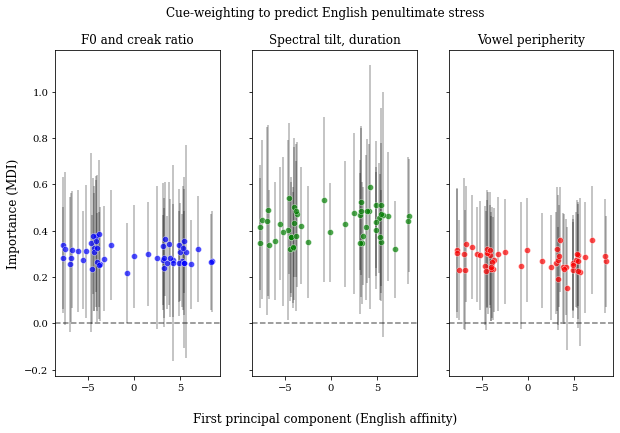

In [5]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc1,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc1, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc1,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc1, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict English penultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

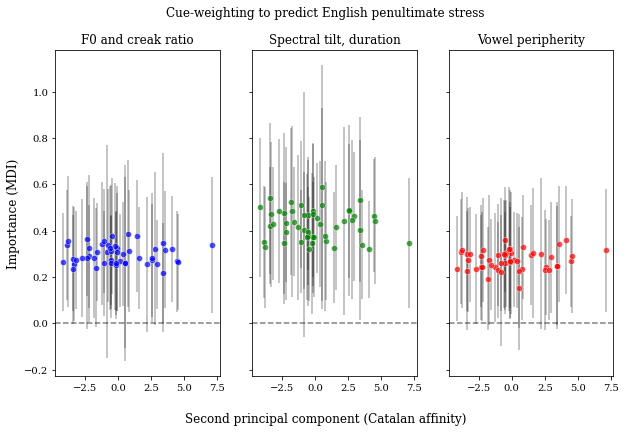

In [6]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc2,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc2, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc2,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc2, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict English penultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

In [7]:
eng_final = df[(df['Language']=="eng") & (df['lang_profile']!='mono') & (df['syllable']=="ult")].copy()
f0_creak = eng_final[eng_final['Feature']=="f0_creak"].copy()
vowel_periph = eng_final[eng_final['Feature']=="vowel_periph"].copy()
spec_dur = eng_final[eng_final['Feature']=="spec_dur"].copy()

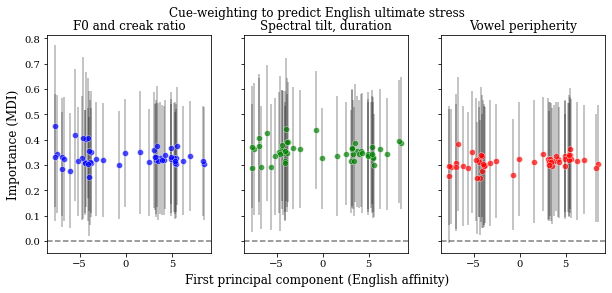

In [8]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc1,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc1, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc1,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc1, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict English ultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

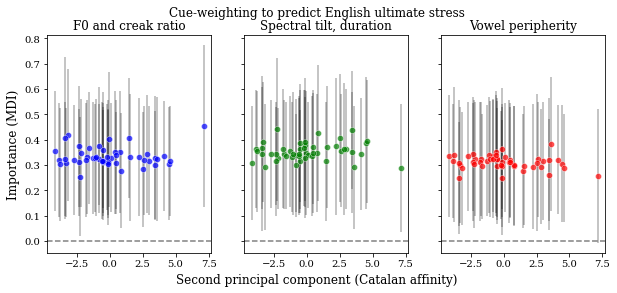

In [9]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc2,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc2, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc2,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc2, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict English ultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

In [10]:
spa_init = df[(df['Language']=="spa") & (df['lang_profile']!='mono') & (df['syllable']=="pen")].copy()
f0_creak = spa_init[spa_init['Feature']=="f0_creak"].copy()
vowel_periph = spa_init[spa_init['Feature']=="vowel_periph"].copy()
spec_dur = spa_init[spa_init['Feature']=="spec_dur"].copy()

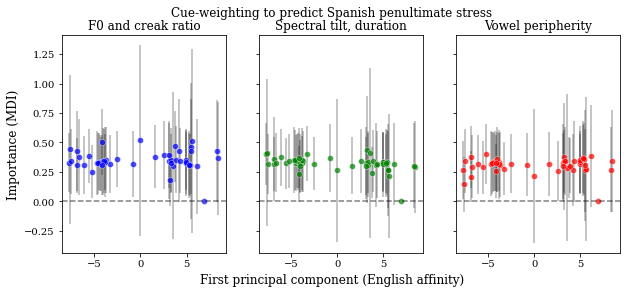

In [11]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc1,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc1, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc1,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc1, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Spanish penultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

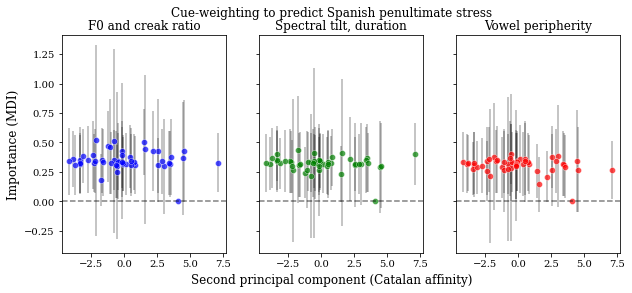

In [12]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc2,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc2, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc2,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc2, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Spanish penultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

In [13]:
spa_final = df[(df['Language']=="spa")& (df['syllable']=="ult")].copy()
f0_creak = spa_final[spa_final['Feature']=="f0_creak"].copy()
vowel_periph = spa_final[spa_final['Feature']=="vowel_periph"].copy()
spec_dur = spa_final[spa_final['Feature']=="spec_dur"].copy()

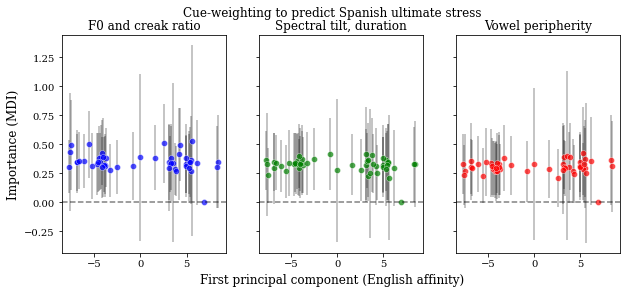

In [14]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc1,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc1, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc1,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc1, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Spanish ultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

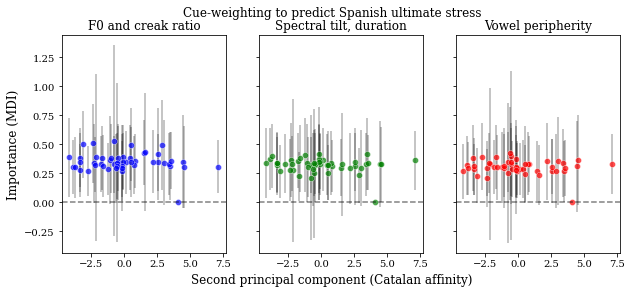

In [15]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc2,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc2, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc2,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc2, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Spanish ultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

In [16]:
cat_init = df[(df['Language']=="cat")& (df['syllable']=="pen")].copy()
f0_creak = cat_init[cat_init['Feature']=="f0_creak"].copy()
vowel_periph = cat_init[cat_init['Feature']=="vowel_periph"].copy()
spec_dur = cat_init[cat_init['Feature']=="spec_dur"].copy()

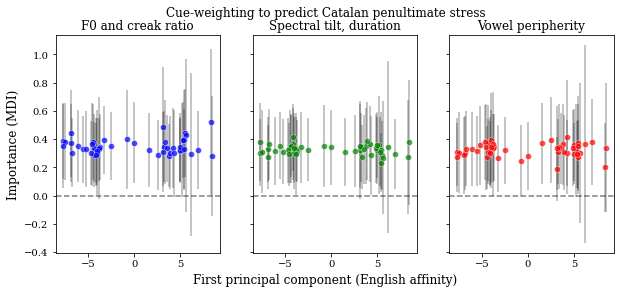

In [17]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc1,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc1, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc1,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc1, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Catalan penultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

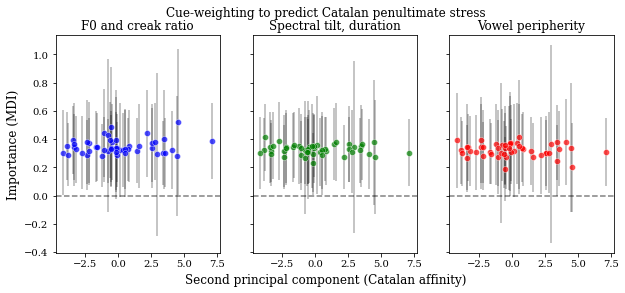

In [18]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc2,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc2, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc2,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc2, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Catalan penultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

In [19]:
cat_final = df[(df['Language']=="cat")& (df['syllable']=="ult")].copy()
f0_creak = cat_final[cat_final['Feature']=="f0_creak"].copy()
vowel_periph = cat_final[cat_final['Feature']=="vowel_periph"].copy()
spec_dur = cat_final[cat_final['Feature']=="spec_dur"].copy()

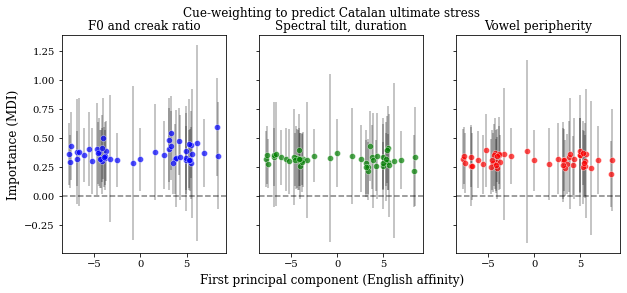

In [20]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc1,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc1, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc1,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc1, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Catalan ultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

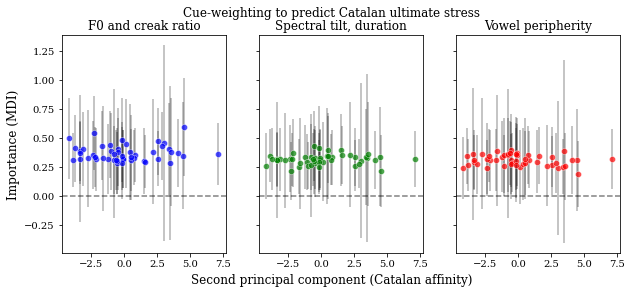

In [21]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,4))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak ratio")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt, duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc2,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc2, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc2,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc2, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("Importance (MDI)")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
# fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Catalan ultimate stress")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

## Get visualization across language profile in English

In [34]:
df_wd.columns

Index(['spec_dur_vowel1', 'vowel_periph_vowel1', 'partID', 'Language',
       'spec_dur_vowel2', 'vowel_periph_vowel2', 'stress_wd',
       'f0_creak_ratio'],
      dtype='object')

In [35]:
df_wd_lang = pd.merge(df_wd, parts, on = "partID", how = "left")
df_wd_lang.head()

,spec_dur_vowel1,vowel_periph_vowel1,partID,Language,spec_dur_vowel2,vowel_periph_vowel2,stress_wd,f0_creak_ratio,lang_profile
0,-2.082444,-0.034866,afs116,cat,4.574169,0.112931,Oxytone,0.586621,l1_eng
1,3.266917,1.798889,afs116,cat,5.502514,0.004191,Oxytone,0.885033,l1_eng
2,4.762114,1.791195,afs116,cat,5.561161,0.379749,Oxytone,0.851287,l1_eng
3,5.082870,1.946327,afs116,cat,5.520534,0.375616,Oxytone,0.889843,l1_eng
4,3.738210,1.443353,afs116,cat,5.946262,0.403462,Oxytone,1.101281,l1_eng


In [36]:
eng_lang = df_wd_lang[df_wd_lang['Language']=="eng"].copy()

In [37]:
y_eng = eng_lang['stress_wd']
X_eng = eng_lang.drop(['stress_wd', 'Language', 'partID', 'lang_profile'], axis = 1)
    
rf_classifier = RandomForestClassifier(random_state = 10)
    
param_grid = { 
    'n_estimators': [500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(4,10,1),
    'criterion' :['gini', 'entropy']
}

CV_rfc_eng = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv= 5)
CV_rfc_eng.fit(X_eng, y_eng)
    
print("Best RF Estimator: ", CV_rfc_eng.best_params_, "\n")
    
scores_eng = cross_val_score(rf_classifier, X_eng, y_eng.ravel(), cv=5)
print("Accuracy over all data: ", scores_eng.mean())
    
rf_classifier_best_eng = CV_rfc_eng.best_estimator_

cols_eng = X_eng.columns

Best RF Estimator:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500} 

Accuracy over all data:  0.7675162790697675


In [38]:
def rf_eng_lang(df, rf_classifier_best, cols):
    lang_profile = []
    stats_list = []
        
    for l in df.lang_profile.unique():
        data = df[df['lang_profile']==l].copy()
        data.drop(['Language', 'partID', 'lang_profile'], axis = 1, inplace = True)
            
        # define predictor label
        y = data['stress_wd']

        # define feature set
        X = data.drop(['stress_wd'], axis = 1)
            
        rf_classifier_best.fit(X, y.ravel())
        stats = cbook.boxplot_stats(np.vstack([tree.feature_importances_ for tree in rf_classifier_best.estimators_]),
                    labels=cols, bootstrap=10000)
        
        stats_list.append(stats)
        lang_profile.append(l)
        
    return(lang_profile, stats_list)

In [39]:
lang_profile_list, stats_list = rf_eng_lang(eng_lang, rf_classifier_best_eng, cols_eng)

In [40]:
lang_profile_list

['l1_eng', 'l3_eng', 'mono']

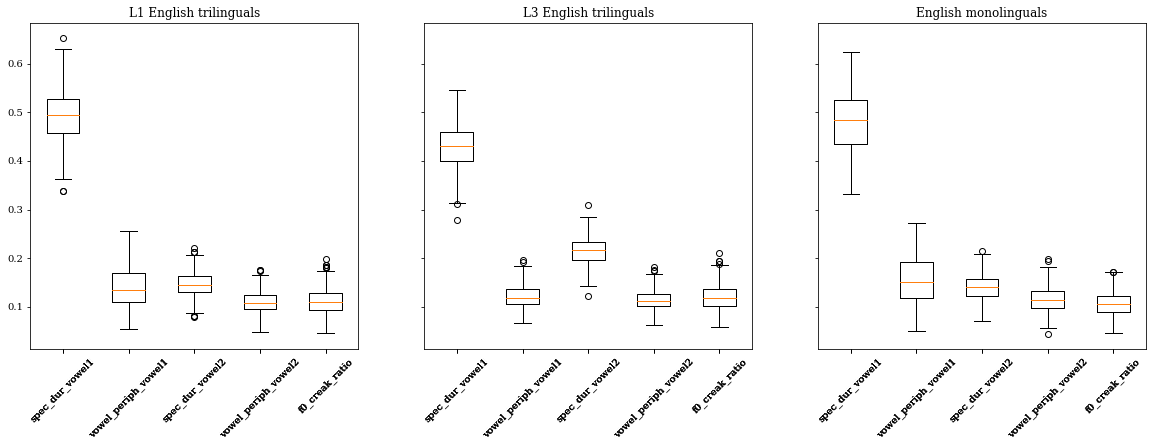

<Figure size 432x288 with 0 Axes>

In [51]:
fig, ax = plt.subplots(1, 3, figsize = (20,6), sharey = True, sharex = True)
ax[0].bxp(stats_list[0])
ax[1].bxp(stats_list[1])
ax[2].bxp(stats_list[2])

ax[0].set_title("L1 English trilinguals")
ax[1].set_title("L3 English trilinguals")
ax[2].set_title("English monolinguals")
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)
# ax.set_title("Feature importances for L1 English trilinguals")
# ax.set_ylabel("Decrease in impurity")
# ax.set_ylim(-0.05,1)
plt.figure();